# Downloading data from Kaggle

# Visualizing data

In [2]:
! pip install pydicom

In [3]:
import pydicom
import pandas as pd

In [4]:
temp_dir = '/data2/yinuo/rsna/stage_2_train_images/'
df = pd.read_csv('/data2/yinuo/rsna/stage_2_train_labels.csv')
print(df.iloc[0])

patientId    0004cfab-14fd-4e49-80ba-63a80b6bddd6
x                                             NaN
y                                             NaN
width                                         NaN
height                                        NaN
Target                                          0
Name: 0, dtype: object


array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'y'}>],
       [<AxesSubplot:title={'center':'width'}>,
        <AxesSubplot:title={'center':'height'}>],
       [<AxesSubplot:title={'center':'Target'}>, <AxesSubplot:>]],
      dtype=object)

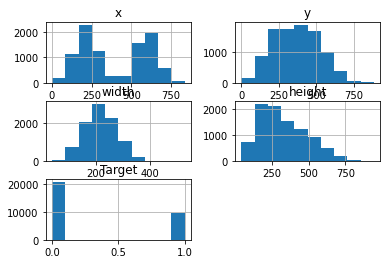

In [5]:
df.hist()

In [6]:
patientId = df['patientId'][0]
dcm_file = temp_dir + '%s.dcm' % patientId
dcm_data = pydicom.read_file(dcm_file)

print(dcm_data)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

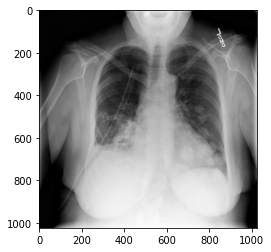

In [7]:
import matplotlib.pyplot as plt

im = dcm_data.pixel_array
plt.imshow(im, cmap=plt.cm.gist_gray)

In [8]:
def parse_data(df, parent_dir):
    """
    Method to read a CSV file (Pandas dataframe) and parse the 
    data into the following nested dictionary:

      parsed = {
        
        'patientId-00': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        },
        'patientId-01': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        }, ...

      }

    """
    # --- Define lambda to extract coords in list [y, x, height, width]
    extract_box = lambda row: [row['y'], row['x'], row['height'], row['width']]

    parsed = {}
    for n, row in df.iterrows():
        # --- Initialize patient entry into parsed 
        pid = row['patientId']
        if pid not in parsed:
            parsed[pid] = {
                'dicom': parent_dir + '%s.dcm' % pid,
                'label': row['Target'],
                'boxes': []}

        # --- Add box if opacity is present
        if parsed[pid]['label'] == 1:
            parsed[pid]['boxes'].append(extract_box(row))

    return parsed

In [9]:
parsed = parse_data(df, temp_dir)
print(parsed['00436515-870c-4b36-a041-de91049b9ab4'])


{'dicom': '/data2/yinuo/rsna/stage_2_train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm', 'label': 1, 'boxes': [[152.0, 264.0, 379.0, 213.0], [152.0, 562.0, 453.0, 256.0]]}


In [10]:
def draw(data):
    """
    Method to draw single patient with bounding box(es) if present 

    """
    # --- Open DICOM file
    d = pydicom.read_file(data['dicom'])
    im = d.pixel_array

    # --- Convert from single-channel grayscale to 3-channel RGB
    im = np.stack([im] * 3, axis=2)

    # --- Add boxes with random color if present
    for box in data['boxes']:
        rgb = np.floor(np.random.rand(3) * 256).astype('int')
        im = overlay_box(im=im, box=box, rgb=rgb, stroke=6)

    plt.imshow(im, cmap=plt.cm.gist_gray)
    

def overlay_box(im, box, rgb, stroke=1):
    """
    Method to overlay single box on image

    """
    # --- Convert coordinates to integers
    box = [int(b) for b in box]
    
    # --- Extract coordinates
    y1, x1, height, width = box
    y2 = y1 + height
    x2 = x1 + width

    im[y1:y1 + stroke, x1:x2] = rgb
    im[y2:y2 + stroke, x1:x2] = rgb
    im[y1:y2, x1:x1 + stroke] = rgb
    im[y1:y2, x2:x2 + stroke] = rgb

    return im

In [11]:
#defected
draw(parsed['00436515-870c-4b36-a041-de91049b9ab4'])

NameError: name 'np' is not defined

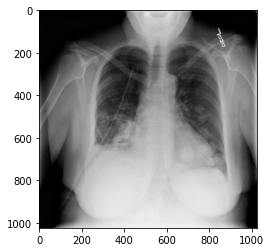

In [ ]:
#healthy
draw(parsed['0004cfab-14fd-4e49-80ba-63a80b6bddd6'])

# Validating data and labels match 

In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import shutil
import glob

In [14]:
filesNum = next(os.walk('/data2/yinuo/rsna/stage_2_train_images/'))[2]
len(filesNum)

26684

In [15]:
df = pd.read_csv('/data2/yinuo/rsna/stage_2_train_labels.csv')
len(df)

30227

# Removing duplicates and sorting by patientId

In [16]:
sorted(os.listdir('/data2/yinuo/rsna/stage_2_train_images/'))

['0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm',
 '000924cf-0f8d-42bd-9158-1af53881a557.dcm',
 '000db696-cf54-4385-b10b-6b16fbb3f985.dcm',
 '000fe35a-2649-43d4-b027-e67796d412e0.dcm',
 '001031d9-f904-4a23-b3e5-2c088acd19c6.dcm',
 '0010f549-b242-4e94-87a8-57d79de215fc.dcm',
 '001916b8-3d30-4935-a5d1-8eaddb1646cd.dcm',
 '0022073f-cec8-42ec-ab5f-bc2314649235.dcm',
 '0022995a-45eb-4cfa-9a59-cd15f5196c64.dcm',
 '0025d2de-bd78-4d36-9f72-e15a5e22ca82.dcm',
 '00293de0-a530-41dc-9621-0b3def01d06d.dcm',
 '002c591d-df62-4e34-8eda-838c664430a9.dcm',
 '002cb550-2e31-42f1-a29d-fbc279977e71.dcm',
 '00313ee0-9eaa-42f4-b0ab-c148ed3241cd.dcm',
 '00322d4d-1c29-4943-afc9-b6754be640eb.dcm',
 '003d8fa0-6bf1-40ed-b54c-ac657f8495c5.dcm',
 '00436515-870c-4b36-a041-de91049b9ab4.dcm',
 '0049f7b2-229b-4a46-91a3-0e321a3ca80a.dcm',
 '0053ee32-1e03-4dc2-a103-f46ad0448787.dcm',
 '00569f44-917d-4c86-a842-81832af98c30.dcm',
 '005f5517-ab76-4b0d-8a26-f808d97171c4.dcm',
 '0067d70b-0e6d-41ff-a9b8-8edf6d5e25e4.dcm',
 '006cec2e

In [17]:
#sorting data by patientId

directory = '/data2/yinuo/rsna/stage_2_train_images/'
out_path = '/data2/yinuo/rsna/data_sorted/'
for filename in sorted(os.listdir(directory)):
  shutil.copy(directory + filename, out_path)
    

In [18]:
filename = next(os.walk('/data2/yinuo/rsna/data_sorted/'))[2]
len(filename)

26684

In [19]:
df.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [20]:
df.drop(columns=['x', 'y', 'width', 'height'], inplace=True)

In [21]:
df.sort_values('patientId', inplace=True)

In [22]:
df.head()

,patientId,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0
28989,000924cf-0f8d-42bd-9158-1af53881a557,0
28990,000db696-cf54-4385-b10b-6b16fbb3f985,1
28991,000db696-cf54-4385-b10b-6b16fbb3f985,1
28992,000fe35a-2649-43d4-b027-e67796d412e0,1


In [23]:
len(df)

30227

In [24]:
df.drop_duplicates(subset='patientId', keep='first', inplace=True)
df.head()

,patientId,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0
28989,000924cf-0f8d-42bd-9158-1af53881a557,0
28990,000db696-cf54-4385-b10b-6b16fbb3f985,1
28992,000fe35a-2649-43d4-b027-e67796d412e0,1
28994,001031d9-f904-4a23-b3e5-2c088acd19c6,1


In [25]:
len(df)

26684

In [26]:
df.head()

,patientId,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0
28989,000924cf-0f8d-42bd-9158-1af53881a557,0
28990,000db696-cf54-4385-b10b-6b16fbb3f985,1
28992,000fe35a-2649-43d4-b027-e67796d412e0,1
28994,001031d9-f904-4a23-b3e5-2c088acd19c6,1


In [27]:
os.listdir('/data2/yinuo/rsna/data_sorted/')[0]

'5352be11-df67-4929-a91a-9412dcb54e2b.dcm'

# Splitting data into train and validation

In [40]:
#splitting into train

directory = '/data2/yinuo/rsna/data_sorted/'
train_path = '/data2/yinuo/rsna/Train/'
for filename in sorted(os.listdir(directory))[: 18679]:
  shutil.copy(directory + filename, train_path)
    

In [41]:
import os
filesNum = next(os.walk('/data2/yinuo/rsna/Train/'))[2]
len(filesNum)

18679

In [50]:
#splitting into validation

val_path = '/data2/yinuo/rsna/Val/'

for filename in sorted(os.listdir(directory))[18679: 22681]:
  shutil.copy(directory + filename, val_path)

In [51]:
import os
filesNum = next(os.walk('/data2/yinuo/rsna/Val/'))[2]
len(filesNum)

4002

In [52]:
#splitting into test

test_path = '/data2/yinuo/rsna/Test/'

for filename in sorted(os.listdir(directory))[22681: ]:
  shutil.copy(directory + filename, test_path)

In [53]:
import os
filesNum = next(os.walk('/data2/yinuo/rsna/Test/'))[2]
len(filesNum)

4003

In [34]:
df_train = pd.DataFrame()
df_train = df.iloc[:18679]
df_train.to_csv('train.csv')

In [35]:
print(len(df_train))
df_train.head()

18679


,patientId,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0
28989,000924cf-0f8d-42bd-9158-1af53881a557,0
28990,000db696-cf54-4385-b10b-6b16fbb3f985,1
28992,000fe35a-2649-43d4-b027-e67796d412e0,1
28994,001031d9-f904-4a23-b3e5-2c088acd19c6,1


In [36]:
df_val = pd.DataFrame()
df_val = df.iloc[18679:22681]
df_val.to_csv('val.csv')

df_test = pd.DataFrame()
df_test = df.iloc[22681:]
df_test.to_csv('test.csv')

In [37]:
print(len(df_test))
df_test.head()

4003


,patientId,Target
24716,ddfcc1a2-9c25-44c8-9b00-c927c1f2369e,0
24717,ddfce2d3-f6aa-4771-8718-1fba8c3add1d,0
24718,ddff3a86-77a1-4a9c-b7cf-2ec5ef401d8a,0
24719,de021bc5-eacc-4c73-a8c2-7f98d5467c52,1
24720,de04a499-1e5c-4a5a-becd-4c6069a7e518,0


# Converting data into PNG format

In [56]:
#converting the training data
import pydicom

inputdir = '/data2/yinuo/rsna/Train/'
outdir = '/data2/yinuo/rsna/train/'

train_list = [ f for f in  sorted(os.listdir(inputdir))]

for f in train_list: 
    ds = pydicom.read_file(inputdir + f, force=True) # read dicom image
    img = ds.pixel_array # get image array
    cv2.imwrite(outdir + f.replace('.dcm','.png'),img) # write png image

In [57]:
import os
filesNum = next(os.walk('/data2/yinuo/rsna/train/'))[2]
len(filesNum)

18679

In [58]:
#converting the validation data

inputdir = '/data2/yinuo/rsna/Val/'
outdir = '/data2/yinuo/rsna/val/'

test_list = [ f for f in  sorted(os.listdir(inputdir))]

for f in test_list:
    ds = pydicom.read_file(inputdir + f, force=True) # read dicom image
    img = ds.pixel_array # get image array
    cv2.imwrite(outdir + f.replace('.dcm','.png'),img) # write png image

In [59]:
#converting the test data

inputdir = '/data2/yinuo/rsna/Test/'
outdir = '/data2/yinuo/rsna/test/'

test_list = [ f for f in  sorted(os.listdir(inputdir))]

for f in test_list:
    ds = pydicom.read_file(inputdir + f, force=True) # read dicom image
    img = ds.pixel_array # get image array
    cv2.imwrite(outdir + f.replace('.dcm','.png'),img) # write png image

In [60]:
import os
filesNum = next(os.walk('/data2/yinuo/rsna/test/'))[2]
len(filesNum)

4003

# Creating custome dataloader and transforms in PyTorch

In [61]:
import torch
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

/home/cihangxie/.conda/envs/yinuo/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [62]:
class RSNA(Dataset):
    def __init__(self, csv_file, id_col, target_col, root_dir, sufix=None, transform=None):
        """
        Args:
            csv_file   (string):             Path to the csv file with annotations.
            root_dir   (string):             Directory with all the images.
            id_col     (string):             csv id column name.
            target_col (string):             csv target column name.
            sufix      (string, optional):   Optional sufix for samples.
            transform  (callable, optional): Optional transform to be applied on a sample.
        """
        self.data      = pd.read_csv(csv_file)
        self.id        = id_col
        #self.target    = target_col
        self.label_arr = np.asarray(self.data.iloc[:, -1])
        self.root      = root_dir
        self.sufix     = sufix
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # get the image name at the different idx
        img_name = self.data.loc[idx, self.id]
        
        # if there is not sufic, nothing happened. in this case sufix is '.jpg'
        if self.sufix is not None:
            img_name = img_name + self.sufix
        
        # it opens the image of the img_name at the specific idx
        image = Image.open(os.path.join(self.root, img_name + '.png'))
        
        # if there is not transform nothing happens, here we defined below two transforms for train and for test
        if self.transform is not None:
            image = self.transform(image)
        
        # define the label based on the idx
        label = self.label_arr[idx]
        
        return image, label

In [63]:

data_trans = transforms.Compose([transforms.Resize(128),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor()
])


data_trans_val = transforms.Compose([transforms.Resize(128),
                                 transforms.ToTensor()
])


# Appling transformation

In [65]:
# transforming training data
train_dataset = RSNA(csv_file='/data2/yinuo/rsna/train.csv',
                           id_col = 'patientId',
                           target_col = 'Target',
                           root_dir='/data2/yinuo/rsna/train/',
                           transform=data_trans)


In [66]:
# transforming validation data
val_dataset = RSNA(csv_file='/data2/yinuo/rsna/val.csv',
                         id_col = 'patientId',
                         target_col = 'Target',
                         root_dir = '/data2/yinuo/rsna/val/',
                         transform=data_trans_val)


In [67]:
loaders_scratch = {'train' : DataLoader(train_dataset,batch_size = 50, num_workers = 4, shuffle=True),
                    'valid' : DataLoader(val_dataset,batch_size = 50, num_workers = 4)}

# CNN Architecture

In [ ]:
model = nn.Sequential(OrderedDict([
                      ('conv1', nn.Conv2d(1, 8, kernel_size=4, stride=1)),
                      ('relu1', nn.ReLU()),
                      ('maxpool1', nn.MaxPool2d(2,stride=2)),
                      ('batchnorm1', nn.BatchNorm2d(8)),
                      ('conv2', nn.Conv2d(8, 16, kernel_size=2)),
                      ('relu2', nn.ReLU()),
                      ('maxpool2', nn.MaxPool2d(2)),
                      ('batchnorm2', nn.BatchNorm2d(16)),
                      ('dropout1', nn.Dropout2d(.25)),
                      ('flatten', nn.Flatten()),
                      ('fc1', nn.Linear(14400, 1000)),
                      ('relu3', nn.ReLU()),
                      ('dropout2', nn.Dropout(.5)),
                      ('fc2', nn.Linear(1000, 2))
]))

model
#16384

Sequential(
  (conv1): Conv2d(1, 8, kernel_size=(4, 4), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batchnorm1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 16, kernel_size=(2, 2), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batchnorm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (flatten): Flatten()
  (fc1): Linear(in_features=14400, out_features=1000, bias=True)
  (relu3): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1000, out_features=2, bias=True)
)

In [ ]:
criterion_scratch = nn.CrossEntropyLoss()
optimizer_scratch = optim.Adam(model.parameters(), lr=.001)

# Training

In [ ]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    correct = 0.
    total = 0.
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for data, target in loaders['train']:
            #print(data.shape)
            #print(target.shape)
            #print(target)
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like            
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            #print(output.shape)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()*data.size(0)
            ###
            
        ######################    
        # validate the model #
        ######################
        model.eval()

        for data, target in loaders['valid']:
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            
            ###
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)

            # convert output probabilities to predicted class
            pred = output.data.max(1, keepdim=True)[1]
            # compare predictions to true label
            correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            total += data.size(0)
            ###
        train_loss = train_loss/len(loaders['train'].dataset) ###
        valid_loss = valid_loss/len(loaders['valid'].dataset) ###

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        #print acc
        print('\nTest Accuracy: %2d%%' % (
        100. * correct / total))

        ##save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model




In [ ]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    model.cuda()

In [ ]:
# train the model
model_scratch = train(5, loaders_scratch, model, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 0.570142 	Validation Loss: 0.452848

Test Accuracy: 86%
Validation loss decreased (inf --> 0.452848).  Saving model ...
Epoch: 2 	Training Loss: 0.567656 	Validation Loss: 0.452549

Test Accuracy: 86%
Validation loss decreased (0.452848 --> 0.452549).  Saving model ...
Epoch: 3 	Training Loss: 0.567485 	Validation Loss: 0.452250

Test Accuracy: 86%
Validation loss decreased (0.452549 --> 0.452250).  Saving model ...
Epoch: 4 	Training Loss: 0.567411 	Validation Loss: 0.452250

Test Accuracy: 86%
Validation loss decreased (0.452250 --> 0.452250).  Saving model ...
Epoch: 5 	Training Loss: 0.567411 	Validation Loss: 0.452250

Test Accuracy: 86%
Validation loss decreased (0.452250 --> 0.452250).  Saving model ...


<All keys matched successfully>

In [ ]:
plt.plot(train_loss, label='Training loss')
plt.plot(valid_loss, label='Validation loss')
plt.legend(frameon=False)